### Model using New Data

In [1]:
import numpy as np
import pandas as pd
from IPython.display import Markdown, display

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import diverging_palette

import sklearn
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

from sklearn.linear_model import (
    LogisticRegression,
    Lasso
)

from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier
)

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    RepeatedStratifiedKFold,
    GridSearchCV,
    KFold
)

from sklearn.metrics import (
    accuracy_score, 
    precision_score, average_precision_score,
    precision_recall_curve,
    confusion_matrix, #plot_confusion_matrix,
    roc_curve, roc_auc_score,
    classification_report
)

import lightgbm as lgb
from lightgbm import LGBMClassifier, plot_importance

#from yellowbrick.classifier import (
#    ConfusionMatrix,
#    ROCAUC
#)

import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore")
simplefilter("ignore", category=ConvergenceWarning)

pd.set_option('display.max_columns', None) # Show all the columns

In [2]:
#pip install --upgrade scikit-learn
import numpy as np
import pandas as pd
from IPython.display import Markdown, display

In [3]:
url = 'https://raw.githubusercontent.com/McGill-MMA-EnterpriseAnalytics/Airline-Passenger-Satisfaction-Prediction-Part2/Dev/Data/df6.csv'
data = pd.read_csv(url)
data

,id,Age,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,satisfaction,Gender_Male,Customer_Type_Loyal Customer,Type_of_Travel_Business travel
0,110028.0,26.0,0.0,1142.0,2.0,2.0,2.0,2.0,5.0,5.0,5.0,5.0,4.0,3.0,4.0,4.0,4.0,5.0,0.0,1.0,0.0,1.0,1.0
1,119299.0,61.0,0.0,214.0,3.0,3.0,3.0,3.0,4.0,5.0,5.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0
2,82113.0,47.0,2.0,1276.0,2.0,4.0,2.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,4.0,3.0,5.0,2.0,9.0,0.0,1.0,1.0,0.0
3,96462.0,52.0,0.0,2035.0,4.0,3.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,1.0,0.0,1.0,1.0
4,65725.0,20.0,2.0,1061.0,3.0,3.0,3.0,4.0,2.0,3.0,3.0,2.0,2.0,3.0,4.0,4.0,3.0,2.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42897,86549.0,26.0,0.0,712.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,3.0,4.0,4.0,3.0,4.0,5.0,17.0,1.0,1.0,1.0,1.0
42898,102203.0,60.0,0.0,1599.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,9.0,1.0,0.0,1.0,1.0
42899,60666.0,50.0,2.0,1620.0,3.0,1.0,3.0,4.0,2.0,3.0,2.0,2.0,4.0,3.0,4.0,2.0,4.0,2.0,0.0,0.0,1.0,1.0,0.0
42900,94171.0,23.0,2.0,192.0,2.0,1.0,2.0,3.0,2.0,2.0,2.0,2.0,3.0,1.0,4.0,2.0,3.0,2.0,3.0,0.0,0.0,0.0,1.0


# Data Preparation

## Standardization of Numeric Variables

In [4]:
numeric_cols = ['Age', 'Flight_Distance','Departure_Delay_in_Minutes']
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

## Handling Missing Values

The satisfaction level of each feature should range from 1 to 5.

If the rating is 0, that means the customer did not rate for this feature.

In [5]:
def list_column_values(df, number_of_values, print_all):
    display(Markdown('**Results:**' ))
    for col in df.columns[0:]:
        if df[col].nunique() <= number_of_values:
            print(f"{col.ljust(25)}" +  ' ==> ' + str(df[col].sort_values().unique().tolist()) )
        else:  
            if print_all=='True':
               
                print(f"{col.ljust(25)}" + ' ==> more than ' + str(number_of_values) + ' values')

list_column_values(data, data.shape[1],'True')

**Results:**

id                        ==> more than 23 values
Age                       ==> more than 23 values
Class                     ==> [0.0, 1.0, 2.0]
Flight_Distance           ==> more than 23 values
Inflight_wifi_service     ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Departure/Arrival_time_convenient ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Ease_of_Online_booking    ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Gate_location             ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Food_and_drink            ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Online_boarding           ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Seat_comfort              ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_entertainment    ==> [1.0, 2.0, 3.0, 4.0, 5.0]
On-board_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Leg_room_service          ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Baggage_handling          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Checkin_service           ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Cleanliness               ==> [1.0, 2.0, 3.

In [6]:
incomplete = ['Inflight_wifi_service','Departure/Arrival_time_convenient',
              'Ease_of_Online_booking','Online_boarding','Leg_room_service']
(data[incomplete] == 0).sum()

Inflight_wifi_service                162
Departure/Arrival_time_convenient    276
Ease_of_Online_booking               145
Online_boarding                        9
Leg_room_service                       3
dtype: int64

#### We should consider rating=0 as missing values as the customer did not provide any rating feedback.

In [7]:
(data[incomplete] == 0).sum().sum()/data.shape[0]

0.013868817304554566

#### Missing ratings only takes up 1.3% of the dataset, try advanced imputation techniques here

## KNN Imputation

In [8]:
#replace the 0 value as nan
data[incomplete] = data[incomplete].replace(0, np.nan)

In [9]:
data[incomplete].isnull().sum()

Inflight_wifi_service                162
Departure/Arrival_time_convenient    276
Ease_of_Online_booking               145
Online_boarding                        9
Leg_room_service                       3
dtype: int64

In [10]:
null_rows_idx = data.isnull().any(axis=1)

data.loc[null_rows_idx].head(3)

,id,Age,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,satisfaction,Gender_Male,Customer_Type_Loyal Customer,Type_of_Travel_Business travel
14,14849.0,-0.056376,0.0,-1.041118,NaN,NaN,NaN,3.0,2.0,5.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,-0.454514,1.0,1.0,1.0,1.0
66,85554.0,0.545156,0.0,-1.020660,NaN,1.0,1.0,1.0,3.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,-0.454514,1.0,0.0,1.0,1.0
342,48727.0,0.620348,0.0,2.036342,NaN,5.0,NaN,4.0,2.0,5.0,5.0,4.0,4.0,4.0,4.0,3.0,4.0,3.0,-0.454514,1.0,0.0,1.0,1.0


In [11]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)

data_num = data.select_dtypes(include=[np.number])
imputer.fit(data_num)

X_ = imputer.transform(data_num)

#save in df4_knn
data_knn = pd.DataFrame(X_, columns=data_num.columns, index=data_num.index)

data_knn.loc[null_rows_idx].head(3)

,id,Age,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,satisfaction,Gender_Male,Customer_Type_Loyal Customer,Type_of_Travel_Business travel
14,14849.0,-0.056376,0.0,-1.041118,3.6,3.6,2.8,3.0,2.0,5.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,-0.454514,1.0,1.0,1.0,1.0
66,85554.0,0.545156,0.0,-1.020660,3.4,1.0,1.0,1.0,3.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,-0.454514,1.0,0.0,1.0,1.0
342,48727.0,0.620348,0.0,2.036342,3.0,5.0,3.0,4.0,2.0,5.0,5.0,4.0,4.0,4.0,4.0,3.0,4.0,3.0,-0.454514,1.0,0.0,1.0,1.0


#### Since the satisfaction level can only be 1,2,3,4, or 5. we need to conver the value to integer

In [12]:
import math

def ceil(x):
    return math.ceil(x - 0.5)

data_knn[incomplete] = data_knn[incomplete].applymap(ceil)

data_knn.loc[null_rows_idx].head(3)

,id,Age,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,satisfaction,Gender_Male,Customer_Type_Loyal Customer,Type_of_Travel_Business travel
14,14849.0,-0.056376,0.0,-1.041118,4,4,3,3.0,2.0,5,3.0,4.0,4.0,4,4.0,4.0,4.0,3.0,-0.454514,1.0,1.0,1.0,1.0
66,85554.0,0.545156,0.0,-1.020660,3,1,1,1.0,3.0,4,5.0,4.0,4.0,4,4.0,4.0,4.0,5.0,-0.454514,1.0,0.0,1.0,1.0
342,48727.0,0.620348,0.0,2.036342,3,5,3,4.0,2.0,5,5.0,4.0,4.0,4,4.0,3.0,4.0,3.0,-0.454514,1.0,0.0,1.0,1.0


In [13]:
list_column_values(data_knn, data_knn.shape[1],'True')

**Results:**

id                        ==> more than 23 values
Age                       ==> more than 23 values
Class                     ==> [0.0, 1.0, 2.0]
Flight_Distance           ==> more than 23 values
Inflight_wifi_service     ==> [1, 2, 3, 4, 5]
Departure/Arrival_time_convenient ==> [1, 2, 3, 4, 5]
Ease_of_Online_booking    ==> [1, 2, 3, 4, 5]
Gate_location             ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Food_and_drink            ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Online_boarding           ==> [1, 2, 3, 4, 5]
Seat_comfort              ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_entertainment    ==> [1.0, 2.0, 3.0, 4.0, 5.0]
On-board_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Leg_room_service          ==> [1, 2, 3, 4, 5]
Baggage_handling          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Checkin_service           ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Cleanliness               ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Departure_Delay_in_Minutes ==> more than 23 values
satisfactio

In [14]:
data_knn = data_knn.drop(columns=['id'])

## Splitting the Dataset

In [15]:
# Identify features and target
X = data_knn.drop(columns=['satisfaction'])
y = data_knn['satisfaction']

### Train Test Split

In [16]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2, random_state = 777)

N_train, _ = X_train.shape 
N_val_test,  _ = X_val_test.shape 

N_train, N_val_test

(34321, 8581)

### Test Validation Split

In [17]:
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5, random_state = 777)

N_val, _ = X_val.shape 
N_test,  _ = X_test.shape 

N_val, N_test

(4290, 4291)

In [18]:
data_knn.columns

Index(['Age', 'Class', 'Flight_Distance', 'Inflight_wifi_service',
       'Departure/Arrival_time_convenient', 'Ease_of_Online_booking',
       'Gate_location', 'Food_and_drink', 'Online_boarding', 'Seat_comfort',
       'Inflight_entertainment', 'On-board_service', 'Leg_room_service',
       'Baggage_handling', 'Checkin_service', 'Inflight_service',
       'Cleanliness', 'Departure_Delay_in_Minutes', 'satisfaction',
       'Gender_Male', 'Customer_Type_Loyal Customer',
       'Type_of_Travel_Business travel'],
      dtype='object')

### The LightGBM After Hyperopt hyperparameters tuning

In [19]:
# Initialize LGBMClassifier with best hyperparameters
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators= 689,
                          learning_rate= 0.017868454799152795,
                          num_leaves=54,
                          max_depth= 6,
                          n_jobs=-1,
                          verbose=-1,
                          random_state=42 )

model_lgbm= lgbm_clf.fit(X_train, y_train)

### SHAP Global Effect Analysis for LightGBM

In [20]:
import shap

In [21]:
# Fits the explainer
explainer = shap.Explainer(model_lgbm, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

100%|===================| 4289/4291 [03:04<00:00]        

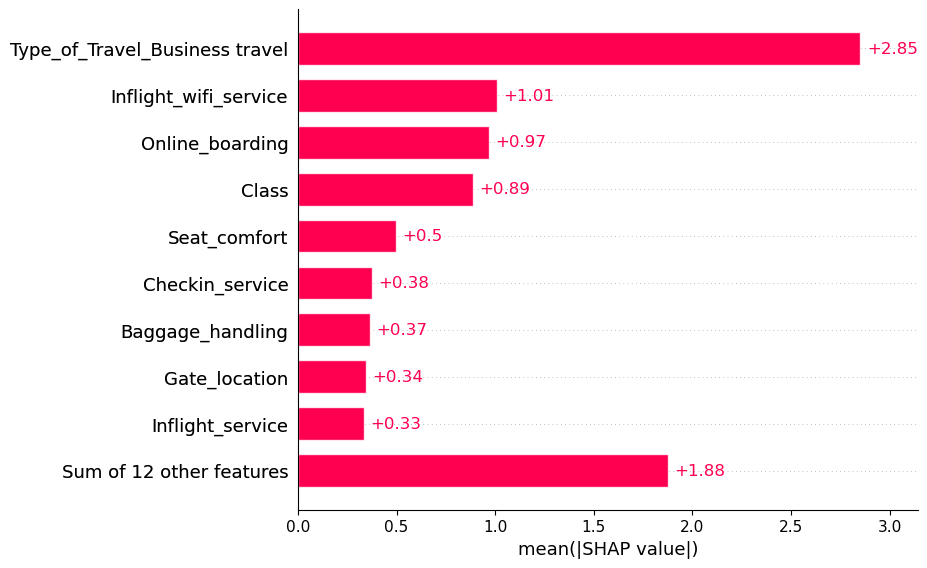

In [22]:
shap.plots.bar(shap_values)

In the above graph, we can see the impact of each variable on the prediction from the highest to the lowest effect. 

The graph shows the absolute SHAP value, so it does not matter if the feature affects the prediction in a positive or negative way.

We can note that the variables with highest impact are:
- Type of Travel (Business or not), 
- Wifi satisfaction level and;
- Online boarding satisfaction level

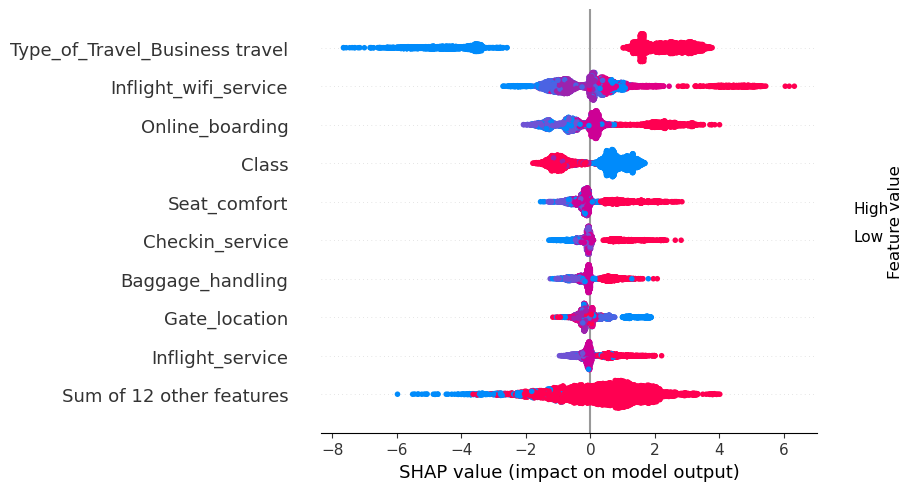

In [23]:
shap.plots.beeswarm(shap_values)

On the beeswarm the features are also ordered by their effect on prediction, but we can also see how higher and lower values of the feature will affect the result.

In our case, we can note that for a customer that is not flying in business travel (low score) there will be a negative impact on the prediction output. In addition, we can see that a high satisfaction with the wifi and online boarding process have a significant positive impact on the prediction. 

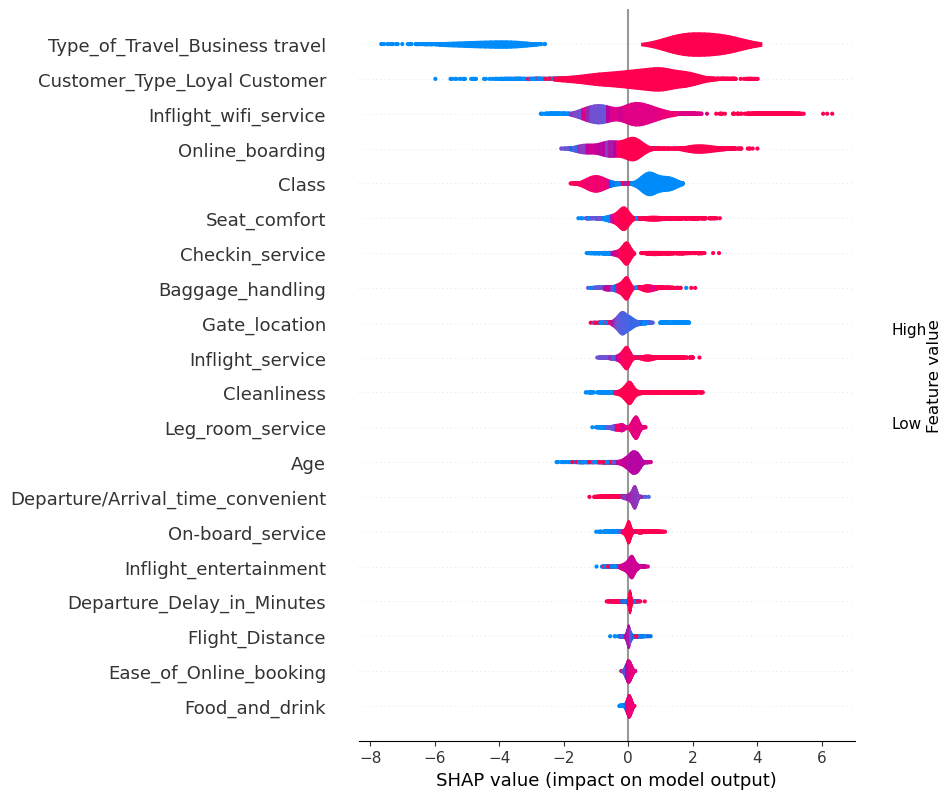

In [24]:
# Another way to see the beeswarm plot is with the violin type
shap.summary_plot(shap_values, plot_type='violin')

### local values

In [56]:
# Get the predictions and put them with the test data.
X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(model_lgbm.predict(X_output),2)

# Randomly pick some observations
random_picks = np.arange(1,330,50) # Every 50 rows
S = X_output.iloc[random_picks]
S

,Age,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Gender_Male,Customer_Type_Loyal Customer,Type_of_Travel_Business travel,predict
36274,0.469965,2.0,-0.272483,1,4,1,3.0,2.0,3,4.0,4.0,4.0,1,4.0,3.0,4.0,4.0,-0.454514,0.0,1.0,0.0,0.0
22140,-0.582716,0.0,0.432829,3,3,5,3.0,3.0,3,3.0,4.0,4.0,4,4.0,5.0,4.0,3.0,1.491503,1.0,1.0,1.0,1.0
15910,-1.109057,0.0,0.748466,3,3,3,3.0,3.0,3,3.0,3.0,4.0,5,4.0,3.0,4.0,3.0,-0.454514,0.0,0.0,1.0,0.0
4669,-0.582716,2.0,-0.667029,2,4,2,4.0,3.0,2,3.0,3.0,3.0,3,5.0,3.0,4.0,3.0,-0.454514,0.0,1.0,0.0,0.0
16864,1.221880,0.0,1.081638,2,2,3,2.0,4.0,4,4.0,5.0,2.0,4,4.0,4.0,4.0,4.0,-0.454514,0.0,1.0,1.0,1.0
2172,1.221880,0.0,0.049973,3,3,3,3.0,4.0,4,4.0,5.0,5.0,5,5.0,4.0,5.0,4.0,-0.454514,0.0,1.0,1.0,1.0
33312,-1.184248,2.0,-0.884273,3,1,3,3.0,4.0,3,4.0,4.0,3.0,1,2.0,4.0,2.0,4.0,-0.454514,1.0,1.0,0.0,0.0


In [59]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

# Write in a function
def shap_plot(j):
    explainerModel = shap.Explainer(model_lgbm,S)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [77]:
X_train.mean()

Age                                 -0.002344
Class                                0.698960
Flight_Distance                      0.003636
Inflight_wifi_service                2.856910
Departure/Arrival_time_convenient    3.146674
Ease_of_Online_booking               2.865447
Gate_location                        2.967891
Food_and_drink                       3.434049
Online_boarding                      3.641706
Seat_comfort                         3.844614
Inflight_entertainment               3.790158
On-board_service                     3.762420
Leg_room_service                     3.679642
Baggage_handling                     3.957606
Checkin_service                      3.601731
Inflight_service                     3.966930
Cleanliness                          3.603217
Departure_Delay_in_Minutes           0.000859
Gender_Male                          0.499927
Customer_Type_Loyal Customer         0.950846
Type_of_Travel_Business travel       0.754553
dtype: float64

In [60]:
shap_plot(1)

The f(x) is the prediction for that observation, in the first case, 3.41.
The base value: is the value that would be predicted if we did not know any features for the current output. In other words, it is the mean prediction.In the first case, the mean prediction of Y_test is -1.853. 
Red/blue: Features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue. In the first case, we can conclude that for this customer, having inflight wifi service, good leg room service, and splendid checkin service that are better than the average level, and lift this customer's satisfication. On contrast, average inflight service and baggage handling, along with inflight service and sear comfort drag down the overall satisfication for this client.

In [74]:
shap_plot(5)

In [76]:
shap_plot(3)